[INFO] 2025-05-06 17:04:56 - Downloading German Credit dataset from OpenML …
[INFO] 2025-05-06 17:04:56 - Dataset shape: 1000 rows × 21 columns
[INFO] 2025-05-06 17:04:56 - Running 5‑fold stratified cross‑validation …
[INFO] 2025-05-06 17:05:00 - CV ROC‑AUC: 0.7789 ± 0.0366
[INFO] 2025-05-06 17:05:00 - Training final model …
[INFO] 2025-05-06 17:05:01 - Accuracy           : 0.7900
[INFO] 2025-05-06 17:05:01 - ROC‑AUC            : 0.7915
[INFO] 2025-05-06 17:05:01 - 
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       140
           1       0.68      0.57      0.62        60

    accuracy                           0.79       200
   macro avg       0.75      0.73      0.74       200
weighted avg       0.78      0.79      0.78       200



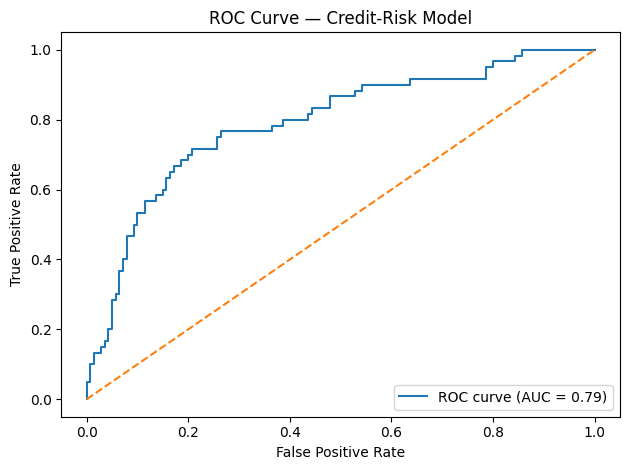

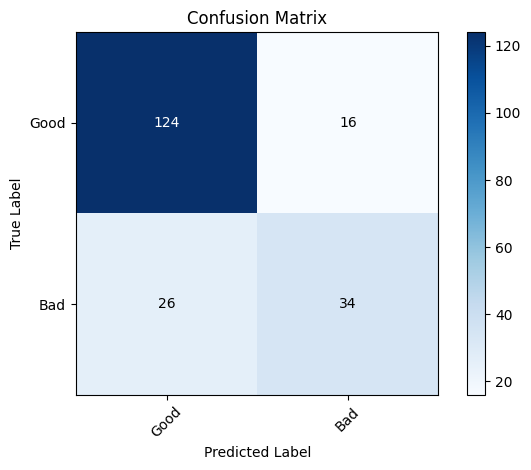

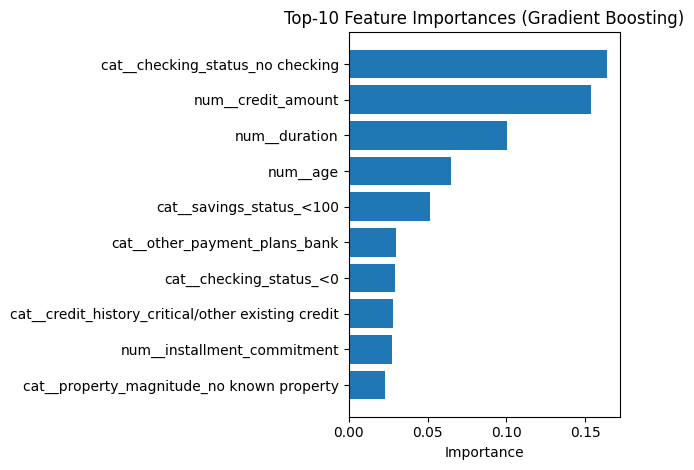

[INFO] 2025-05-06 17:05:02 - Saved trained pipeline to artifacts/credit_risk_pipeline.joblib


In [ ]:
"""
Title: End‑to‑End Credit‑Risk Scoring Pipeline
Author: Adarsh S
Description:
    This script trains, evaluates, and persists a production‑ready credit‑risk
    scoring model using the German Credit Data (OpenML id=31) as an example.
    The code is structured for clarity and extensibility so you can swap in
    another dataset or model with minimal changes.
"""

# %%
# Standard library
from __future__ import annotations
import logging
from dataclasses import dataclass
from pathlib import Path
from typing import Tuple, List

# Third‑party
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
# %%
@dataclass
class Config:
    random_state: int = 42
    test_size: float = 0.2
    n_splits_cv: int = 5
    target_column: str = "class"
    model_output_path: Path = Path("artifacts/credit_risk_pipeline.joblib")
    figures_dir: Path = Path("figures")


CFG = Config()

# -----------------------------------------------------------------------------
# Helper functions
# -----------------------------------------------------------------------------
# %%

def _setup_logging() -> None:
    """Configure basic logging to stdout."""
    logging.basicConfig(
        level=logging.INFO,
        format="[%(levelname)s] %(asctime)s - %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
        force=True,  # makes sure re‑running the cell resets config
    )


# %%

def load_german_credit() -> pd.DataFrame:
    """Fetch the German Credit Data from OpenML as a pandas DataFrame."""
    logging.info("Downloading German Credit dataset from OpenML …")
    dataset = fetch_openml("credit-g", version=1, as_frame=True)
    df = dataset.frame
    logging.info("Dataset shape: %s rows × %s columns", *df.shape)
    return df


# %%

def split_features_target(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """Split DataFrame into X (features) and y (binary‑encoded target)."""
    X = df.drop(columns=[CFG.target_column])
    y = df[CFG.target_column].map({"good": 0, "bad": 1})  # encode
    return X, y


# %%

def build_preprocessing_pipeline(X: pd.DataFrame) -> Tuple[ColumnTransformer, List[str], List[str]]:
    """Create preprocessing ColumnTransformer for numeric & categorical cols."""
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = [c for c in X.columns if c not in numeric_features]

    numeric_pipeline = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    categorical_pipeline = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_pipeline, numeric_features),
            ("cat", categorical_pipeline, categorical_features),
        ]
    )
    return preprocessor, numeric_features, categorical_features


# %%

def build_model_pipeline(preprocessor: ColumnTransformer) -> Pipeline:
    """Combine preprocessing with a Gradient Boosting classifier inside a Pipeline."""
    model = GradientBoostingClassifier(random_state=CFG.random_state)
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("estimator", model),
        ]
    )
    return pipeline


# %%

def visualise_metrics(pipeline: Pipeline, X_test: pd.DataFrame, y_test: pd.Series) -> None:
    """Plot ROC curve, confusion matrix heatmap, and feature importances."""
    CFG.figures_dir.mkdir(parents=True, exist_ok=True)

    # --- ROC curve ---
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve — Credit‑Risk Model")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # --- Confusion matrix ---
    y_pred = pipeline.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Good", "Bad"], rotation=45)
    plt.yticks(tick_marks, ["Good", "Bad"])
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], "d"), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

    # --- Feature importances ---
    # Pull out feature names after preprocessing
    feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
    importances = pipeline.named_steps["estimator"].feature_importances_

    sorted_idx = np.argsort(importances)[::-1][:10]  # top‑10
    plt.figure()
    plt.barh(range(len(sorted_idx)), importances[sorted_idx][::-1])
    plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx][::-1])
    plt.title("Top‑10 Feature Importances (Gradient Boosting)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()


# %%

def evaluate_model(pipeline: Pipeline, X_test: pd.DataFrame, y_test: pd.Series) -> None:
    """Print textual metrics and call visualise_metrics for plots."""
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    logging.info("Accuracy           : %.4f", accuracy_score(y_test, y_pred))
    logging.info("ROC‑AUC            : %.4f", roc_auc_score(y_test, y_proba))
    logging.info("\nClassification Report\n%s", classification_report(y_test, y_pred))

    visualise_metrics(pipeline, X_test, y_test)


# %%

def cross_validate_model(pipeline: Pipeline, X: pd.DataFrame, y: pd.Series) -> None:
    """Run K‑fold cross‑validation and log mean/std ROC‑AUC."""
    logging.info("Running %d‑fold stratified cross‑validation …", CFG.n_splits_cv)
    cv = StratifiedKFold(
        n_splits=CFG.n_splits_cv, shuffle=True, random_state=CFG.random_state
    )
    scores = cross_val_score(
        pipeline, X, y, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=0
    )
    logging.info("CV ROC‑AUC: %.4f ± %.4f", scores.mean(), scores.std())


# %%

def save_pipeline(pipeline: Pipeline) -> None:
    """Persist the trained pipeline to disk for later inference."""
    CFG.model_output_path.parent.mkdir(parents=True, exist_ok=True)
    joblib.dump(pipeline, CFG.model_output_path)
    logging.info("Saved trained pipeline to %s", CFG.model_output_path)


# -----------------------------------------------------------------------------
# Main flow — designed for notebook execution, but also works as a script.
# -----------------------------------------------------------------------------
# %%

def main() -> None:
    _setup_logging()

    # 1. Load data
    df = load_german_credit()

    # 2. Train‑test split
    X, y = split_features_target(df)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=CFG.test_size,
        stratify=y,
        random_state=CFG.random_state,
    )

    # 3. Build preprocessing & model pipeline
    preprocessor, *_ = build_preprocessing_pipeline(X_train)
    pipeline = build_model_pipeline(preprocessor)

    # 4. Cross‑validation on training data
    cross_validate_model(pipeline, X_train, y_train)

    # 5. Fit on full training data
    logging.info("Training final model …")
    pipeline.fit(X_train, y_train)

    # 6. Evaluate on hold‑out test data
    evaluate_model(pipeline, X_test, y_test)

    # 7. Persist the pipeline for production use
    save_pipeline(pipeline)


# %%
if __name__ == "__main__":
    main()
